In [1]:
# Here some codes are from this tutorial by Ori Cohen
# https://towardsdatascience.com/active-learning-tutorial-57c3398e34d

import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
import sklearn
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

max_queried = 500

In [2]:
def download(dataset='mnist_784'):
    if dataset == 'mnist_784':
        mnist = fetch_openml(dataset)
        X = mnist.data.astype('float64')
        y = mnist.target
        print ('MNIST:', X.shape, y.shape)
    else:
        wisconsin = sklearn.datasets.load_breast_cancer()
        X = wisconsin.data.astype('float64')
        y = wisconsin.target
        print ('breast cancer Wisconsin:', X.shape, y.shape)
    return (X, y)


def split(train_size=60000):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)

In [3]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with Linear Kernel'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training SVM...')
        self.classifier = SVC(
            C=1, 
            kernel='linear', 
            probability=True, 
            class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        
        return (X_train, X_val, X_test, \
                self.val_y_predicted, self.test_y_predicted)


class NbModel(BaseModel):

    model_type = 'Naive Bayes Classifier' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training Naive Bayes')
        self.classifier = GaussianNB()
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        
        return (X_train, X_val, X_test, \
                self.val_y_predicted, self.test_y_predicted)


class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print('training Random Forest...')
        self.classifier = RandomForestClassifier(
            n_estimators=500, 
            class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        
        return (X_train, X_val, X_test, \
                self.val_y_predicted, self.test_y_predicted)

In [4]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.f1_scores = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. 
    # i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print('Train set:', X_train.shape, 'y:', y_train.shape, end='')
        print('Val   set:', X_val.shape, end='')
        print('Test  set:', X_test.shape)
        t0 = time.time()
        
        (X_train, X_val, X_test, 
        self.val_y_predicted, self.test_y_predicted) \
            = self.model_object.fit_predict(
                X_train, y_train, X_val, X_test, c_weight)
        
        self.run_time = time.time() - t0
        # we return them only in case we use PCA
        return (X_train, X_val, X_test)

    # we want accuracy only for the test set
    def get_test_accuracy(self, i, y_test):

        accuracy = np.mean(self.test_y_predicted.ravel() == y_test.ravel())
        f1score = f1_score(y_test, self.test_y_predicted, average='weighted')
        f1score = float("{:.3f}".format(float(f1score)))
        self.accuracies.append(accuracy)
        self.f1_scores.append(f1score)

        print('--------------------------------')
        print('Iteration:', i)
        print('Example run in {:.3f} s'.format(self.run_time))
        print('Accuracy rate: {:.3f}%, F1-score: {}'.format(
            accuracy * 100, f1score))    
        print('--------------------------------')


In [5]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(
            probas_val.shape[0], initial_labeled_samples, replace=False)
        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(entropy)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [6]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test)

In [7]:
def get_k_random_samples(
    initial_labeled_samples, X_train_full, y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(
        X_train_full.shape[0], 
        size=initial_labeled_samples, 
        replace=False)
    print('initial random chosen samples', permutation.shape)

    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]

    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print(
        'initial train set:', X_train.shape, y_train.shape,
        'unique(labels):', bin_count, unique)
    return (permutation, X_train, y_train)

In [8]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # assign the val set the rest of the 'unlabelled' training data
        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print('val set:', X_val.shape, y_val.shape, permutation.shape)

        # normalize data
        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)      
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = \
            self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        while self.queried < max_queried:
            active_iteration += 1
            # get validation probabilities
            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)

            uncertain_samples = \
                self.sample_selection_function.select(
                    probas_val, self.initial_labeled_samples)
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set
            print('trainset before', X_train.shape, y_train.shape, end='')
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print('updated train set:', X_train.shape, y_train.shape, 
            'unique(labels):', bin_count, unique)

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print('val set:', X_val.shape, y_val.shape)

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = \
                self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print('final active learning accuracies', self.clf_model.accuracies)

In [9]:
(X, y) = download('mnist_784')
(X_train_full, y_train_full, X_test, y_test) = split(60000)
print ('train:', X_train_full.shape, y_train_full.shape, end='  ')
print ('test :', X_test.shape, y_test.shape, end='  ')
classes = len(np.unique(y))
print ('unique classes', classes)

MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)  test : (10000, 784) (10000,)  unique classes 10


In [10]:
def pickle_save(fname, data):
    filehandler = open(fname, 'wb')
    pickle.dump(data,filehandler)
    filehandler.close() 
    print('saved', fname, os.getcwd(), os.listdir())


def pickle_load(fname):
    print(os.getcwd(), os.listdir())
    file = open(fname, 'rb')
    data = pickle.load(file)
    file.close()
    print(data)
    return data

In [11]:
def experiment(d, models, selection_functions, Ks, countfrom):
    print ('stopping at:', max_queried)
    count = 0

    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []                     
            count += 1
            if count >= countfrom:
                print (
                    'Count = {}, using model = {}, selection_function = {}, k = {}'\
                    .format(count, model_object.__name__, selection_function.__name__, k)
                )
                alg = TheAlgorithm(k, model_object, selection_function)
                alg.run(X_train_full, y_train_full, X_test, y_test)
                d[model_object.__name__][selection_function.__name__][str(k)].append(
                    (alg.clf_model.accuracies, alg.clf_model.f1_scores))
                fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                pickle_save(fname, d)
                if count % 5 == 0:
                    print(json.dumps(d, indent=2, sort_keys=True))
                print ('\n----------FINISHED--------------\n')
    return d

In [12]:
max_queried = 500 
models = [NbModel, SvmModel, RfModel] 
selection_functions = [
    RandomSelection, 
    MarginSamplingSelection, 
    EntropySelection] 
Ks = [10, 50, 100, 250] 

d = {}
stopped_at = -1 

d = experiment(d, models, selection_functions, Ks, stopped_at+1)
print(d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

with open('results.json', 'w') as f:
    json.dump(results, f)

stopping at: 500
Count = 1, using model = NbModel, selection_function = RandomSelection, k = 10
initial random chosen samples (10,)
initial train set: (10, 784) (10,) unique(labels): [2 0 1 1 1 1 0 2 1 1] [0 2 3 4 5 7 8 9]
val set: (59990, 784) (59990,) (10,)
Train set: (10, 784) y: (10,)Val   set: (59990, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 1
Example run in 2.092 s
Accuracy rate: 14.530%, F1-score: 0.082
--------------------------------
trainset before (10, 784) (10,)trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [2 1 4 3 2 1 2 3 1 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)
Train set: (20, 784) y: (20,)Val   set: (59980, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 3.132 s
Accuracy rate: 30.320%, F1-score: 0.235
--------------------------------
trainset before (20, 784) (20,)trainset after (30, 784) (30,)
updated trai

--------------------------------
Iteration: 19
Example run in 2.746 s
Accuracy rate: 59.850%, F1-score: 0.6
--------------------------------
trainset before (190, 784) (190,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [30 16 21 23 23 18 24 18 11 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 20
Example run in 2.562 s
Accuracy rate: 58.750%, F1-score: 0.59
--------------------------------
trainset before (200, 784) (200,)trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [30 16 21 25 23 20 24 19 14 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)
Train set: (210, 784) y: (210,)Val   set: (59790, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 21
Example run in 2.565 s
Accuracy rate: 59.090%, F1-score: 0.594
-

Train set: (380, 784) y: (380,)Val   set: (59620, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 38
Example run in 2.944 s
Accuracy rate: 59.820%, F1-score: 0.603
--------------------------------
trainset before (380, 784) (380,)trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [51 31 38 41 41 41 44 39 32 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)
Train set: (390, 784) y: (390,)Val   set: (59610, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 39
Example run in 2.624 s
Accuracy rate: 60.000%, F1-score: 0.605
--------------------------------
trainset before (390, 784) (390,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [52 32 40 43 43 42 44 40 32 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Naive Bayes
---------

Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.541 s
Accuracy rate: 55.990%, F1-score: 0.578
--------------------------------
trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [10 16 24 19 14  9 11 21 11 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 3
Example run in 2.566 s
Accuracy rate: 58.530%, F1-score: 0.6
--------------------------------
trainset before (150, 784) (150,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [14 19 31 26 18 17 14 25 14 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
-------------

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 1
Example run in 2.604 s
Accuracy rate: 57.540%, F1-score: 0.582
--------------------------------
trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [63 62 49 51 47 40 48 53 38 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.985 s
Accuracy rate: 57.330%, F1-score: 0.572
--------------------------------
final active learning accuracies [0.5754, 0.5733]
saved Active-learning-experiment-4.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5

Train set: (140, 784) y: (140,)Val   set: (59860, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 14
Example run in 2.537 s
Accuracy rate: 49.880%, F1-score: 0.492
--------------------------------
trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 8 25  3  8 19 14  5 16 12 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 15
Example run in 2.575 s
Accuracy rate: 49.920%, F1-score: 0.493
--------------------------------
trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [ 8 25  3  9 21 14  5 17 12 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training Naive Bayes
---------

--------------------------------
Iteration: 32
Example run in 2.516 s
Accuracy rate: 50.640%, F1-score: 0.503
--------------------------------
trainset before (320, 784) (320,)trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [ 17  33   3  14  40  19   5  43  16 140] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)
Train set: (330, 784) y: (330,)Val   set: (59670, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 33
Example run in 2.527 s
Accuracy rate: 50.700%, F1-score: 0.503
--------------------------------
trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [ 17  33   3  14  40  19   5  44  16 149] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 34
Example run in 2.529 s
Accuracy rate: 50.

--------------------------------
Iteration: 50
Example run in 3.143 s
Accuracy rate: 49.010%, F1-score: 0.48
--------------------------------
final active learning accuracies [0.1633, 0.2996, 0.3304, 0.3781, 0.4061, 0.4548, 0.462, 0.448, 0.4549, 0.4709, 0.4741, 0.4969, 0.4976, 0.4988, 0.4992, 0.4974, 0.5008, 0.5028, 0.508, 0.508, 0.5085, 0.5084, 0.5084, 0.5087, 0.5096, 0.5093, 0.5098, 0.5097, 0.5075, 0.506, 0.5061, 0.5064, 0.507, 0.5087, 0.5092, 0.5097, 0.5063, 0.4926, 0.4879, 0.4905, 0.4883, 0.4882, 0.4855, 0.4877, 0.4881, 0.4884, 0.4883, 0.4883, 0.4886, 0.4901]
saved Active-learning-experiment-5.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9

trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [14 16  3  5 10 15  8 54 10 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 3
Example run in 2.885 s
Accuracy rate: 50.100%, F1-score: 0.489
--------------------------------
trainset before (150, 784) (150,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [15 18  3 10 14 16  9 86 12 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 4
Example run in 3.410 s
Accuracy rate: 52.260%, F1-score: 0.515
--------------------------------
trainset before (200, 784) (200,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 1
Example run in 2.936 s
Accuracy rate: 63.680%, F1-score: 0.641
--------------------------------
trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [61 41 23 59 74 26 22 54 55 85] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.706 s
Accuracy rate: 63.730%, F1-score: 0.636
--------------------------------
final active learning accuracies [0.6368, 0.6373]
saved Active-learning-experiment-8.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (10, 784) (10,)trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 0 2 2 0 4 2 4 2 3] [0 2 3 5 6 7 8 9]
val set: (59980, 784) (59980,)
Train set: (20, 784) y: (20,)Val   set: (59980, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.116 s
Accuracy rate: 27.010%, F1-score: 0.212
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (20, 784) (20,)trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [3 0 3 3 3 4 4 4 2 4] [0 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)
Train set: (30, 784) y: (30,)Val   set: (59970, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 3
Example run in 2.401 s
Accuracy rate: 39.940%, F1-score: 0.344
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (30, 784) (30,)trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [3 2 3 4 3 7 4 6 4 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)
Train set: (40, 784) y: (40,)Val   set: (59960, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 4
Example run in 2.609 s
Accuracy rate: 42.020%, F1-score: 0.382
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (40, 784) (40,)trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [3 2 5 6 3 8 6 6 7 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)
Train set: (50, 784) y: (50,)Val   set: (59950, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 5
Example run in 2.561 s
Accuracy rate: 45.210%, F1-score: 0.416
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (50, 784) (50,)trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [4 4 7 6 4 8 6 7 8 6] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)
Train set: (60, 784) y: (60,)Val   set: (59940, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 6
Example run in 2.518 s
Accuracy rate: 47.860%, F1-score: 0.436
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (60, 784) (60,)trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 6  6  7  6  4 10  6  9 10  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)
Train set: (70, 784) y: (70,)Val   set: (59930, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 7
Example run in 2.525 s
Accuracy rate: 49.730%, F1-score: 0.482
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (70, 784) (70,)trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 6  7  9  7  5 12  7 10 11  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)
Train set: (80, 784) y: (80,)Val   set: (59920, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 8
Example run in 3.037 s
Accuracy rate: 53.950%, F1-score: 0.52
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (80, 784) (80,)trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 6 10  9  7  5 14  7 12 12  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)
Train set: (90, 784) y: (90,)Val   set: (59910, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 9
Example run in 3.032 s
Accuracy rate: 53.990%, F1-score: 0.522
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (90, 784) (90,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 8 11 10  9  7 14  7 13 12  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 10
Example run in 2.994 s
Accuracy rate: 53.820%, F1-score: 0.528
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 9 12 11 10  8 15  8 13 12 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)
Train set: (110, 784) y: (110,)Val   set: (59890, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 11
Example run in 2.568 s
Accuracy rate: 53.120%, F1-score: 0.524
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (110, 784) (110,)trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [10 14 11 11 10 15  9 14 14 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)
Train set: (120, 784) y: (120,)Val   set: (59880, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 12
Example run in 2.574 s
Accuracy rate: 54.040%, F1-score: 0.539
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (120, 784) (120,)trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [10 17 12 12 11 16  9 16 15 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)
Train set: (130, 784) y: (130,)Val   set: (59870, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 13
Example run in 2.541 s
Accuracy rate: 53.780%, F1-score: 0.538
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (130, 784) (130,)trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [11 18 14 13 13 16 10 16 15 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)
Train set: (140, 784) y: (140,)Val   set: (59860, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 14
Example run in 2.564 s
Accuracy rate: 53.280%, F1-score: 0.532
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [11 18 16 14 14 17 13 16 17 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 15
Example run in 2.582 s
Accuracy rate: 53.760%, F1-score: 0.536
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [12 19 17 14 15 17 16 17 17 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 16
Example run in 2.553 s
Accuracy rate: 53.940%, F1-score: 0.54
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (160, 784) (160,)trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [13 20 17 14 16 20 17 18 18 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)
Train set: (170, 784) y: (170,)Val   set: (59830, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 17
Example run in 2.537 s
Accuracy rate: 56.320%, F1-score: 0.563
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (170, 784) (170,)trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [14 21 18 16 17 23 17 18 19 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)
Train set: (180, 784) y: (180,)Val   set: (59820, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 18
Example run in 2.543 s
Accuracy rate: 54.480%, F1-score: 0.553
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (180, 784) (180,)trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [14 21 20 17 17 24 21 18 20 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)
Train set: (190, 784) y: (190,)Val   set: (59810, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 19
Example run in 2.535 s
Accuracy rate: 55.440%, F1-score: 0.563
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (190, 784) (190,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [14 22 20 17 20 26 22 19 22 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 20
Example run in 2.547 s
Accuracy rate: 55.750%, F1-score: 0.569
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [15 23 20 19 20 26 23 19 23 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)
Train set: (210, 784) y: (210,)Val   set: (59790, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 21
Example run in 2.546 s
Accuracy rate: 56.940%, F1-score: 0.574
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (210, 784) (210,)trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [17 25 20 20 21 27 24 20 24 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)
Train set: (220, 784) y: (220,)Val   set: (59780, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 22
Example run in 2.573 s
Accuracy rate: 57.780%, F1-score: 0.582
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (220, 784) (220,)trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [18 25 20 21 21 29 26 20 25 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)
Train set: (230, 784) y: (230,)Val   set: (59770, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 23
Example run in 2.533 s
Accuracy rate: 58.190%, F1-score: 0.592
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (230, 784) (230,)trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [20 27 20 21 22 29 26 21 27 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)
Train set: (240, 784) y: (240,)Val   set: (59760, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 24
Example run in 3.333 s
Accuracy rate: 58.260%, F1-score: 0.593
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (240, 784) (240,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [21 29 21 21 22 29 30 22 28 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)
Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 25
Example run in 2.771 s
Accuracy rate: 58.460%, F1-score: 0.595
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [24 30 21 22 24 30 31 22 28 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)
Train set: (260, 784) y: (260,)Val   set: (59740, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 26
Example run in 3.043 s
Accuracy rate: 59.450%, F1-score: 0.603
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (260, 784) (260,)trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [24 32 24 23 25 31 32 22 29 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)
Train set: (270, 784) y: (270,)Val   set: (59730, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 27
Example run in 2.696 s
Accuracy rate: 59.640%, F1-score: 0.606
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (270, 784) (270,)trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [25 32 24 24 26 32 36 22 29 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)
Train set: (280, 784) y: (280,)Val   set: (59720, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 28
Example run in 2.551 s
Accuracy rate: 60.380%, F1-score: 0.615
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (280, 784) (280,)trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [26 32 25 25 26 32 37 25 30 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)
Train set: (290, 784) y: (290,)Val   set: (59710, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 29
Example run in 2.537 s
Accuracy rate: 61.150%, F1-score: 0.621
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (290, 784) (290,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [28 33 27 26 26 33 37 26 30 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 30
Example run in 2.567 s
Accuracy rate: 60.700%, F1-score: 0.615
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [28 34 28 27 28 34 38 27 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)
Train set: (310, 784) y: (310,)Val   set: (59690, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 31
Example run in 2.568 s
Accuracy rate: 60.360%, F1-score: 0.613
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (310, 784) (310,)trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [30 36 29 27 30 34 40 27 31 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)
Train set: (320, 784) y: (320,)Val   set: (59680, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 32
Example run in 2.557 s
Accuracy rate: 59.860%, F1-score: 0.608
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (320, 784) (320,)trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [32 37 30 28 33 36 40 27 31 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)
Train set: (330, 784) y: (330,)Val   set: (59670, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 33
Example run in 2.646 s
Accuracy rate: 59.580%, F1-score: 0.605
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [32 39 30 28 33 39 41 28 32 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 34
Example run in 2.568 s
Accuracy rate: 60.670%, F1-score: 0.611
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (340, 784) (340,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [32 40 31 29 33 40 42 30 33 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 35
Example run in 2.528 s
Accuracy rate: 60.590%, F1-score: 0.61
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (350, 784) (350,)trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [32 42 32 29 35 42 42 30 35 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)
Train set: (360, 784) y: (360,)Val   set: (59640, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 36
Example run in 2.571 s
Accuracy rate: 61.310%, F1-score: 0.619
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (360, 784) (360,)trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [33 42 33 32 35 42 42 31 37 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)
Train set: (370, 784) y: (370,)Val   set: (59630, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 37
Example run in 2.554 s
Accuracy rate: 60.480%, F1-score: 0.611
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (370, 784) (370,)trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [33 44 34 33 37 44 42 32 37 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)
Train set: (380, 784) y: (380,)Val   set: (59620, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 38
Example run in 2.567 s
Accuracy rate: 59.850%, F1-score: 0.604
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (380, 784) (380,)trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [35 45 34 35 37 44 43 33 39 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)
Train set: (390, 784) y: (390,)Val   set: (59610, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 39
Example run in 2.549 s
Accuracy rate: 59.910%, F1-score: 0.606
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (390, 784) (390,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [35 45 34 38 39 44 44 36 40 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 40
Example run in 2.545 s
Accuracy rate: 59.350%, F1-score: 0.598
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [37 45 35 39 39 46 45 38 40 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)
Train set: (410, 784) y: (410,)Val   set: (59590, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 41
Example run in 2.527 s
Accuracy rate: 59.240%, F1-score: 0.596
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (410, 784) (410,)trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [37 47 35 39 41 49 47 39 40 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)
Train set: (420, 784) y: (420,)Val   set: (59580, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 42
Example run in 2.574 s
Accuracy rate: 59.240%, F1-score: 0.596
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (420, 784) (420,)trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [39 49 37 40 42 50 47 39 40 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)
Train set: (430, 784) y: (430,)Val   set: (59570, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 43
Example run in 2.518 s
Accuracy rate: 58.060%, F1-score: 0.587
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (430, 784) (430,)trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [41 49 38 43 42 51 48 39 41 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)
Train set: (440, 784) y: (440,)Val   set: (59560, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 44
Example run in 2.549 s
Accuracy rate: 58.120%, F1-score: 0.588
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (440, 784) (440,)trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [42 49 39 45 45 52 48 39 41 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)
Train set: (450, 784) y: (450,)Val   set: (59550, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 45
Example run in 2.545 s
Accuracy rate: 58.070%, F1-score: 0.588
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (450, 784) (450,)trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [44 49 40 47 45 54 49 40 41 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)
Train set: (460, 784) y: (460,)Val   set: (59540, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 46
Example run in 2.616 s
Accuracy rate: 58.220%, F1-score: 0.589
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (460, 784) (460,)trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [45 50 41 48 47 55 50 41 42 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)
Train set: (470, 784) y: (470,)Val   set: (59530, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 47
Example run in 2.529 s
Accuracy rate: 58.450%, F1-score: 0.592
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (470, 784) (470,)trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [45 52 44 48 47 56 50 42 43 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)
Train set: (480, 784) y: (480,)Val   set: (59520, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 48
Example run in 2.565 s
Accuracy rate: 59.010%, F1-score: 0.596
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (480, 784) (480,)trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [46 53 45 48 47 58 52 43 44 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)
Train set: (490, 784) y: (490,)Val   set: (59510, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 49
Example run in 2.559 s
Accuracy rate: 59.210%, F1-score: 0.598
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (490, 784) (490,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [46 56 45 49 49 58 52 46 45 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 50
Example run in 2.524 s
Accuracy rate: 59.290%, F1-score: 0.598
--------------------------------
final active learning accuracies [0.1871, 0.2701, 0.3994, 0.4202, 0.4521, 0.4786, 0.4973, 0.5395, 0.5399, 0.5382, 0.5312, 0.5404, 0.5378, 0.5328, 0.5376, 0.5394, 0.5632, 0.5448, 0.5544, 0.5575, 0.5694, 0.5778, 0.5819, 0.5826, 0.5846, 0.5945, 0.5964, 0.6038, 0.6115, 0.607, 0.6036, 0.5986, 0.5958, 0.6067, 0.6059, 0.6131, 0.6048, 0.5985, 0.5991, 0.5935, 0.5924, 0.5924, 0.5806, 0.5812, 0.5807, 0.5822, 0.5845, 0.5901, 0.5921, 0.5929]
saved Active-learning-experiment-9.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-ex

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (50, 784) (50,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [10  8  7  4 12 12 10 11 18  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.562 s
Accuracy rate: 48.380%, F1-score: 0.486
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [14 16 12  9 19 16 14 16 23 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 3
Example run in 2.580 s
Accuracy rate: 54.490%, F1-score: 0.556
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (150, 784) (150,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [17 22 17 14 24 24 20 19 26 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 4
Example run in 2.567 s
Accuracy rate: 56.130%, F1-score: 0.571
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [21 29 18 19 29 30 28 21 32 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)
Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 5
Example run in 2.539 s
Accuracy rate: 58.900%, F1-score: 0.606
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [28 32 22 23 32 34 36 25 38 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 6
Example run in 2.542 s
Accuracy rate: 59.910%, F1-score: 0.614
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [33 38 24 27 39 40 41 28 42 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 7
Example run in 2.535 s
Accuracy rate: 61.140%, F1-score: 0.623
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (350, 784) (350,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [38 46 29 31 44 44 43 36 45 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 8
Example run in 2.527 s
Accuracy rate: 60.970%, F1-score: 0.618
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [42 50 33 37 53 50 47 40 49 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)
Train set: (450, 784) y: (450,)Val   set: (59550, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 9
Example run in 2.896 s
Accuracy rate: 61.010%, F1-score: 0.615
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (450, 784) (450,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [49 51 41 43 58 55 52 44 52 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 10
Example run in 2.560 s
Accuracy rate: 60.780%, F1-score: 0.61
--------------------------------
final active learning accuracies [0.3146, 0.4838, 0.5449, 0.5613, 0.589, 0.5991, 0.6114, 0.6097, 0.6101, 0.6078]
saved Active-learning-experiment-10.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML 

Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 1
Example run in 2.574 s
Accuracy rate: 54.450%, F1-score: 0.552
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [22 23 17 23 17 19 13 21 27 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.632 s
Accuracy rate: 61.400%, F1-score: 0.625
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [32 41 28 31 27 27 22 31 34 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 3
Example run in 2.557 s
Accuracy rate: 67.470%, F1-score: 0.682
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [45 50 33 42 35 40 37 37 43 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 4
Example run in 2.567 s
Accuracy rate: 68.080%, F1-score: 0.688
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [51 62 38 54 49 53 46 49 49 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 5
Example run in 2.540 s
Accuracy rate: 65.080%, F1-score: 0.655
--------------------------------
final active learning accuracies [0.5445, 0.614, 0.6747, 0.6808, 0.6508]
saved Active-learning-experiment-11.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pd

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [51 61 47 42 52 52 46 45 53 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 2.539 s
Accuracy rate: 58.970%, F1-score: 0.586
--------------------------------
final active learning accuracies [0.575, 0.5897]
saved Active-learning-experiment-12.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pdf', 'Active-learning-exp

trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [11 17 15 17 14 19 12 16 15 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 15
Example run in 8.465 s
Accuracy rate: 79.820%, F1-score: 0.798
--------------------------------
trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [11 20 15 18 16 20 13 16 16 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 16
Example run in 8.933 s
Accuracy rate: 80.240%, F1-score: 0.801
--------------------------------
trainset before (160, 784) (160,)trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels):

--------------------------------
Iteration: 33
Example run in 16.214 s
Accuracy rate: 84.590%, F1-score: 0.846
--------------------------------
trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [21 50 39 36 32 35 27 34 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 34
Example run in 16.637 s
Accuracy rate: 84.790%, F1-score: 0.848
--------------------------------
trainset before (340, 784) (340,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [21 53 39 37 34 36 28 35 31 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 35
Example run in 17.176 s
Accuracy rate: 84.820%, F1-score: 0.849
-----

Train set: (50, 784) y: (50,)Val   set: (59950, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 3.036 s
Accuracy rate: 61.940%, F1-score: 0.59
--------------------------------
trainset before (50, 784) (50,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 7 13  9  6 12 13  8 15  9  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 5.964 s
Accuracy rate: 74.510%, F1-score: 0.739
--------------------------------
trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [13 21 16 12 14 16 12 21 12 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training SVM...
-------------------------------

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 13.139 s
Accuracy rate: 83.720%, F1-score: 0.837
--------------------------------
trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [51 60 46 42 44 58 55 48 51 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 21.833 s
Accuracy rate: 86.930%, F1-score: 0.869
--------------------------------
final active learning accuracies [0.8372, 0.8693]
saved Active-learning-experiment-16.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 

Train set: (140, 784) y: (140,)Val   set: (59860, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 14
Example run in 8.388 s
Accuracy rate: 82.060%, F1-score: 0.821
--------------------------------
trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [13 13 14 15 18 20 11 14 14 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 15
Example run in 8.864 s
Accuracy rate: 82.520%, F1-score: 0.825
--------------------------------
trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [14 13 17 16 18 21 11 17 14 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training SVM...
------------------------

Train set: (330, 784) y: (330,)Val   set: (59670, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 33
Example run in 19.226 s
Accuracy rate: 86.700%, F1-score: 0.866
--------------------------------
trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [22 23 39 32 42 39 26 33 44 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 34
Example run in 19.608 s
Accuracy rate: 87.110%, F1-score: 0.87
--------------------------------
trainset before (340, 784) (340,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [22 23 40 34 42 41 28 35 44 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training SVM...
-----------------------

Train set: (50, 784) y: (50,)Val   set: (59950, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 3.034 s
Accuracy rate: 61.190%, F1-score: 0.601
--------------------------------
trainset before (50, 784) (50,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [13 10  9 17  7 10  8  8  9  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 5.760 s
Accuracy rate: 72.940%, F1-score: 0.727
--------------------------------
trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [16 10 12 22 12 17 13 16 18 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training SVM...
------------------------------

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 13.031 s
Accuracy rate: 83.750%, F1-score: 0.836
--------------------------------
trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [45 32 58 51 61 62 42 49 54 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 25.372 s
Accuracy rate: 87.490%, F1-score: 0.874
--------------------------------
final active learning accuracies [0.8375, 0.8749]
saved Active-learning-experiment-20.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 

Train set: (10, 784) y: (10,)Val   set: (59990, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 0.654 s
Accuracy rate: 36.850%, F1-score: 0.294
--------------------------------
trainset before (10, 784) (10,)trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [0 1 1 9 1 3 2 2 1] [1 2 3 4 5 6 7 8]
val set: (59980, 784) (59980,)
Train set: (20, 784) y: (20,)Val   set: (59980, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 1.251 s
Accuracy rate: 38.630%, F1-score: 0.309
--------------------------------
trainset before (20, 784) (20,)trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [8 1 1 9 1 3 4 2 1] [0 1 2 3 4 5 6 7 8]
val set: (59970, 784) (59970,)
Train set: (30, 784) y: (30,)Val   set: (59970, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 3
Example run in 1.664 s
Accur

Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 20
Example run in 10.977 s
Accuracy rate: 71.860%, F1-score: 0.719
--------------------------------
trainset before (200, 784) (200,)trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [30  6 18 22 19 32 20 19 21 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)
Train set: (210, 784) y: (210,)Val   set: (59790, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 21
Example run in 11.273 s
Accuracy rate: 72.440%, F1-score: 0.724
--------------------------------
trainset before (210, 784) (210,)trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [30 10 20 23 19 33 20 20 21 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)
Train set: (220, 784) y: (220,)Val   set: (59780, 784)Test  set: (10000, 784)
training SVM...
----------------------

Train set: (390, 784) y: (390,)Val   set: (59610, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 39
Example run in 21.887 s
Accuracy rate: 74.370%, F1-score: 0.745
--------------------------------
trainset before (390, 784) (390,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [31 26 39 44 38 61 31 39 43 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 40
Example run in 22.134 s
Accuracy rate: 75.120%, F1-score: 0.752
--------------------------------
trainset before (400, 784) (400,)trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [31 27 40 44 40 63 31 39 46 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)
Train set: (410, 784) y: (410,)Val   set: (59590, 784)Test  set: (10000, 784)
training SVM...
----------------------

Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 3
Example run in 7.934 s
Accuracy rate: 72.180%, F1-score: 0.723
--------------------------------
trainset before (150, 784) (150,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [10  7 40 11 14 24 19 50 15 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 4
Example run in 10.874 s
Accuracy rate: 70.980%, F1-score: 0.71
--------------------------------
trainset before (200, 784) (200,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [10  7 42 16 22 38 21 52 22 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)
Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training SVM...
--------------------------

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 1
Example run in 12.764 s
Accuracy rate: 81.900%, F1-score: 0.817
--------------------------------
trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 26  38  46  39  37 145  34  45  57  33] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training SVM...
--------------------------------
Iteration: 2
Example run in 22.731 s
Accuracy rate: 82.780%, F1-score: 0.827
--------------------------------
final active learning accuracies [0.819, 0.8278]
saved Active-learning-experiment-24.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment

Train set: (140, 784) y: (140,)Val   set: (59860, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 14
Example run in 5.445 s
Accuracy rate: 75.790%, F1-score: 0.753
--------------------------------
trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [15 21 19 16 13 16 11 14 15 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 15
Example run in 5.497 s
Accuracy rate: 78.200%, F1-score: 0.779
--------------------------------
trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [16 22 22 16 14 16 12 15 15 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training Random Fore

--------------------------------
Iteration: 32
Example run in 6.186 s
Accuracy rate: 84.430%, F1-score: 0.842
--------------------------------
trainset before (320, 784) (320,)trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [33 43 42 27 36 25 32 31 35 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)
Train set: (330, 784) y: (330,)Val   set: (59670, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 33
Example run in 6.213 s
Accuracy rate: 84.900%, F1-score: 0.847
--------------------------------
trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [34 44 43 30 37 25 33 31 37 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 34
Example run in 6.242 s
Accuracy rate: 84.430%, F1-s

Train set: (50, 784) y: (50,)Val   set: (59950, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 1
Example run in 4.774 s
Accuracy rate: 60.300%, F1-score: 0.56
--------------------------------
trainset before (50, 784) (50,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [12  7 13 13  6  4 14  4 10 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 5.190 s
Accuracy rate: 68.420%, F1-score: 0.67
--------------------------------
trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [15 11 21 17  9 10 20  7 17 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Random Forest...
--

--------------------------------
Iteration: 5
Example run in 6.603 s
Accuracy rate: 87.690%, F1-score: 0.876
--------------------------------
final active learning accuracies [0.6808, 0.7985, 0.8444, 0.8517, 0.8769]
saved Active-learning-experiment-27.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pdf', 'Active-learning-experiment-30.pkl', 'Active-learning-experiment-18.pkl', 'Active-learning-experiment-19.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-15.pkl', 'Active-learning-experiment-22.pkl', 'Active-learning-experiment-20.pkl', 'Active-learning-experiment-16.pkl', 'A

Train set: (90, 784) y: (90,)Val   set: (59910, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 9
Example run in 5.231 s
Accuracy rate: 76.060%, F1-score: 0.757
--------------------------------
trainset before (90, 784) (90,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 9  6 12 11  9  9  9  7 14 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 10
Example run in 5.296 s
Accuracy rate: 77.890%, F1-score: 0.777
--------------------------------
trainset before (100, 784) (100,)trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 9  6 13 12  9 13 10  7 16 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)
Train set: (110, 784) y: (110,)Val   set: (59890, 784)Test  set: (10000, 784)
training Random Forest...

--------------------------------
Iteration: 27
Example run in 6.315 s
Accuracy rate: 88.230%, F1-score: 0.882
--------------------------------
trainset before (270, 784) (270,)trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [19 10 30 36 31 36 21 26 41 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)
Train set: (280, 784) y: (280,)Val   set: (59720, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 28
Example run in 6.440 s
Accuracy rate: 88.900%, F1-score: 0.889
--------------------------------
trainset before (280, 784) (280,)trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [19 10 32 39 32 36 21 27 42 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)
Train set: (290, 784) y: (290,)Val   set: (59710, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 29
Example run in 6.415 s
Accuracy rate: 88.930%, F1-s

trainset before (450, 784) (450,)trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [28 17 51 60 50 61 38 42 62 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)
Train set: (460, 784) y: (460,)Val   set: (59540, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 46
Example run in 7.385 s
Accuracy rate: 92.640%, F1-score: 0.926
--------------------------------
trainset before (460, 784) (460,)trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [29 17 52 60 50 62 39 43 63 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)
Train set: (470, 784) y: (470,)Val   set: (59530, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 47
Example run in 7.432 s
Accuracy rate: 92.700%, F1-score: 0.927
--------------------------------
trainset before (470, 784) (470,)trainset after (480, 784) (480,)
updated train set: (480, 784) (4

--------------------------------
Iteration: 9
Example run in 8.919 s
Accuracy rate: 92.370%, F1-score: 0.924
--------------------------------
trainset before (450, 784) (450,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [37 25 58 57 55 62 46 35 72 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 10
Example run in 8.060 s
Accuracy rate: 92.470%, F1-score: 0.925
--------------------------------
final active learning accuracies [0.6706, 0.7388, 0.831, 0.8561, 0.8861, 0.8997, 0.907, 0.9165, 0.9237, 0.9247]
saved Active-learning-experiment-30.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Ac

Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 1
Example run in 5.299 s
Accuracy rate: 75.250%, F1-score: 0.749
--------------------------------
trainset before (100, 784) (100,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [22  7 22 22 25 25 14 16 24 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 5.952 s
Accuracy rate: 83.470%, F1-score: 0.835
--------------------------------
trainset before (200, 784) (200,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [22 11 33 29 39 35 27 34 39 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Random Forest

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (20, 784) (20,)trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [5 2 4 4 2 4 0 2 7] [0 1 2 3 4 5 7 8]
val set: (59970, 784) (59970,)
Train set: (30, 784) y: (30,)Val   set: (59970, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 4.931 s
Accuracy rate: 48.800%, F1-score: 0.457
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (30, 784) (30,)trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [14  2  5  4  2  4  0  2  7] [0 1 2 3 4 5 7 8]
val set: (59960, 784) (59960,)
Train set: (40, 784) y: (40,)Val   set: (59960, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 4
Example run in 4.461 s
Accuracy rate: 44.990%, F1-score: 0.426
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (40, 784) (40,)trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [23  2  6  4  2  4  0  2  7] [0 1 2 3 4 5 7 8]
val set: (59950, 784) (59950,)
Train set: (50, 784) y: (50,)Val   set: (59950, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 5
Example run in 4.557 s
Accuracy rate: 45.850%, F1-score: 0.423
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (50, 784) (50,)trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [30  2  6  5  2  4  1  2  8] [0 1 2 3 4 5 6 7 8]
val set: (59940, 784) (59940,)
Train set: (60, 784) y: (60,)Val   set: (59940, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 6
Example run in 4.655 s
Accuracy rate: 45.840%, F1-score: 0.434
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (60, 784) (60,)trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [32  4  6  5  2  4  1  5 11] [0 1 2 3 4 5 6 7 8]
val set: (59930, 784) (59930,)
Train set: (70, 784) y: (70,)Val   set: (59930, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 7
Example run in 4.934 s
Accuracy rate: 46.810%, F1-score: 0.41
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (70, 784) (70,)trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [36  6  6  5  2  4  1  8 12] [0 1 2 3 4 5 6 7 8]
val set: (59920, 784) (59920,)
Train set: (80, 784) y: (80,)Val   set: (59920, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 8
Example run in 5.037 s
Accuracy rate: 48.650%, F1-score: 0.424
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (80, 784) (80,)trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [37  7  7  6  2  4  1 11 13  2] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)
Train set: (90, 784) y: (90,)Val   set: (59910, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 9
Example run in 5.386 s
Accuracy rate: 49.150%, F1-score: 0.429
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (90, 784) (90,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [38  7  9  6  4  4  1 15 14  2] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 10
Example run in 5.633 s
Accuracy rate: 52.440%, F1-score: 0.462
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [41 10  9  6  4  4  1 17 14  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)
Train set: (110, 784) y: (110,)Val   set: (59890, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 11
Example run in 5.170 s
Accuracy rate: 54.630%, F1-score: 0.485
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (110, 784) (110,)trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [41 11 12  7  4  4  1 20 16  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)
Train set: (120, 784) y: (120,)Val   set: (59880, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 12
Example run in 5.044 s
Accuracy rate: 53.510%, F1-score: 0.472
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (120, 784) (120,)trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [43 14 12  7  4  6  1 22 17  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)
Train set: (130, 784) y: (130,)Val   set: (59870, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 13
Example run in 5.163 s
Accuracy rate: 56.700%, F1-score: 0.51
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (130, 784) (130,)trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [44 15 12  8  4  6  1 27 19  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)
Train set: (140, 784) y: (140,)Val   set: (59860, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 14
Example run in 5.579 s
Accuracy rate: 57.680%, F1-score: 0.516
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (140, 784) (140,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [46 17 12  8  4  6  1 30 21  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 15
Example run in 5.509 s
Accuracy rate: 57.950%, F1-score: 0.52
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (150, 784) (150,)trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [48 20 12  8  4  8  1 32 21  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)
Train set: (160, 784) y: (160,)Val   set: (59840, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 16
Example run in 5.592 s
Accuracy rate: 58.590%, F1-score: 0.539
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (160, 784) (160,)trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [50 22 12  9  4  8  1 35 21  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)
Train set: (170, 784) y: (170,)Val   set: (59830, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 17
Example run in 5.740 s
Accuracy rate: 59.700%, F1-score: 0.555
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (170, 784) (170,)trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [51 25 12 10  4  9  1 37 22  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)
Train set: (180, 784) y: (180,)Val   set: (59820, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 18
Example run in 5.683 s
Accuracy rate: 59.460%, F1-score: 0.553
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (180, 784) (180,)trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [51 30 12 10  4  9  1 40 23 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)
Train set: (190, 784) y: (190,)Val   set: (59810, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 19
Example run in 5.515 s
Accuracy rate: 60.180%, F1-score: 0.564
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (190, 784) (190,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [52 31 12 12  6 10  1 41 24 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 20
Example run in 5.442 s
Accuracy rate: 62.500%, F1-score: 0.587
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [53 31 13 13  6 10  1 45 25 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)
Train set: (210, 784) y: (210,)Val   set: (59790, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 21
Example run in 5.484 s
Accuracy rate: 62.610%, F1-score: 0.589
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (210, 784) (210,)trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [55 33 14 13  6 11  1 48 26 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)
Train set: (220, 784) y: (220,)Val   set: (59780, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 22
Example run in 5.547 s
Accuracy rate: 62.390%, F1-score: 0.584
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (220, 784) (220,)trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [57 36 15 13  7 11  1 48 27 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)
Train set: (230, 784) y: (230,)Val   set: (59770, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 23
Example run in 5.648 s
Accuracy rate: 65.370%, F1-score: 0.621
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (230, 784) (230,)trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [58 37 15 14  9 12  1 50 27 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)
Train set: (240, 784) y: (240,)Val   set: (59760, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 24
Example run in 5.643 s
Accuracy rate: 65.670%, F1-score: 0.621
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (240, 784) (240,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [59 40 15 15 10 13  1 51 28 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)
Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 25
Example run in 5.746 s
Accuracy rate: 66.830%, F1-score: 0.635
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [59 45 15 15 10 14  2 54 28 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)
Train set: (260, 784) y: (260,)Val   set: (59740, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 26
Example run in 5.739 s
Accuracy rate: 68.290%, F1-score: 0.654
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (260, 784) (260,)trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [59 52 15 15 10 15  2 55 28 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)
Train set: (270, 784) y: (270,)Val   set: (59730, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 27
Example run in 5.751 s
Accuracy rate: 67.850%, F1-score: 0.648
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (270, 784) (270,)trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [61 57 15 15 10 15  2 57 28 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)
Train set: (280, 784) y: (280,)Val   set: (59720, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 28
Example run in 5.746 s
Accuracy rate: 67.400%, F1-score: 0.643
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (280, 784) (280,)trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [61 65 15 15 10 15  2 59 28 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)
Train set: (290, 784) y: (290,)Val   set: (59710, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 29
Example run in 5.750 s
Accuracy rate: 68.110%, F1-score: 0.647
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (290, 784) (290,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [62 69 15 16 10 15  2 63 28 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 30
Example run in 5.859 s
Accuracy rate: 68.030%, F1-score: 0.648
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [64 73 15 16 10 15  2 67 28 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)
Train set: (310, 784) y: (310,)Val   set: (59690, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 31
Example run in 5.836 s
Accuracy rate: 67.880%, F1-score: 0.645
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (310, 784) (310,)trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [66 76 15 17 10 15  2 71 28 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)
Train set: (320, 784) y: (320,)Val   set: (59680, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 32
Example run in 5.822 s
Accuracy rate: 66.540%, F1-score: 0.634
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (320, 784) (320,)trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [67 82 16 17 10 15  2 71 29 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)
Train set: (330, 784) y: (330,)Val   set: (59670, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 33
Example run in 5.875 s
Accuracy rate: 67.470%, F1-score: 0.642
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (330, 784) (330,)trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [70 84 16 17 10 16  2 74 29 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)
Train set: (340, 784) y: (340,)Val   set: (59660, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 34
Example run in 5.877 s
Accuracy rate: 67.030%, F1-score: 0.637
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (340, 784) (340,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [70 90 16 18 10 16  2 76 30 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 35
Example run in 5.883 s
Accuracy rate: 67.740%, F1-score: 0.644
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (350, 784) (350,)trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [70 96 16 18 10 16  2 78 31 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)
Train set: (360, 784) y: (360,)Val   set: (59640, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 36
Example run in 6.047 s
Accuracy rate: 66.990%, F1-score: 0.637
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (360, 784) (360,)trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [ 70 101  16  18  10  17   2  80  31  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)
Train set: (370, 784) y: (370,)Val   set: (59630, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 37
Example run in 5.914 s
Accuracy rate: 67.080%, F1-score: 0.635
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (370, 784) (370,)trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [ 71 106  17  18  10  18   2  81  31  26] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)
Train set: (380, 784) y: (380,)Val   set: (59620, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 38
Example run in 5.954 s
Accuracy rate: 67.860%, F1-score: 0.646
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (380, 784) (380,)trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [ 71 110  17  19  10  18   2  86  31  26] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)
Train set: (390, 784) y: (390,)Val   set: (59610, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 39
Example run in 5.946 s
Accuracy rate: 67.220%, F1-score: 0.639
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (390, 784) (390,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 71 117  17  20  10  18   2  86  32  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 40
Example run in 5.999 s
Accuracy rate: 67.450%, F1-score: 0.643
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [ 72 121  17  20  10  19   2  88  32  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)
Train set: (410, 784) y: (410,)Val   set: (59590, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 41
Example run in 6.039 s
Accuracy rate: 67.560%, F1-score: 0.641
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (410, 784) (410,)trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [ 74 122  18  20  10  19   2  91  34  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)
Train set: (420, 784) y: (420,)Val   set: (59580, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 42
Example run in 6.014 s
Accuracy rate: 67.590%, F1-score: 0.644
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (420, 784) (420,)trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [ 74 125  18  20  10  19   2  96  36  30] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)
Train set: (430, 784) y: (430,)Val   set: (59570, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 43
Example run in 6.008 s
Accuracy rate: 67.460%, F1-score: 0.641
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (430, 784) (430,)trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [ 74 131  18  20  10  19   2  98  37  31] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)
Train set: (440, 784) y: (440,)Val   set: (59560, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 44
Example run in 6.154 s
Accuracy rate: 67.140%, F1-score: 0.638
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (440, 784) (440,)trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [ 74 137  18  20  10  19   2 101  37  32] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)
Train set: (450, 784) y: (450,)Val   set: (59550, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 45
Example run in 6.186 s
Accuracy rate: 66.730%, F1-score: 0.632
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (450, 784) (450,)trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [ 75 139  18  20  11  19   2 104  38  34] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)
Train set: (460, 784) y: (460,)Val   set: (59540, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 46
Example run in 6.089 s
Accuracy rate: 67.000%, F1-score: 0.637
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (460, 784) (460,)trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [ 76 143  18  20  11  20   2 105  40  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)
Train set: (470, 784) y: (470,)Val   set: (59530, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 47
Example run in 6.077 s
Accuracy rate: 67.230%, F1-score: 0.638
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (470, 784) (470,)trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [ 77 147  19  20  12  20   2 107  41  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)
Train set: (480, 784) y: (480,)Val   set: (59520, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 48
Example run in 6.159 s
Accuracy rate: 66.830%, F1-score: 0.633
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (480, 784) (480,)trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [ 77 152  19  20  12  20   2 111  42  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)
Train set: (490, 784) y: (490,)Val   set: (59510, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 49
Example run in 6.171 s
Accuracy rate: 67.060%, F1-score: 0.635
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (490, 784) (490,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 80 155  21  20  12  21   2 112  42  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 50
Example run in 6.171 s
Accuracy rate: 67.600%, F1-score: 0.642
--------------------------------
final active learning accuracies [0.3532, 0.4418, 0.488, 0.4499, 0.4585, 0.4584, 0.4681, 0.4865, 0.4915, 0.5244, 0.5463, 0.5351, 0.567, 0.5768, 0.5795, 0.5859, 0.597, 0.5946, 0.6018, 0.625, 0.6261, 0.6239, 0.6537, 0.6567, 0.6683, 0.6829, 0.6785, 0.674, 0.6811, 0.6803, 0.6788, 0.6654, 0.6747, 0.6703, 0.6774, 0.6699, 0.6708, 0.6786, 0.6722, 0.6745, 0.6756, 0.6759, 0.6746, 0.6714, 0.6673, 0.67, 0.6723, 0.6683, 0.6706, 0.676]
saved Active-learning-experiment-33.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-le

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (50, 784) (50,)trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 3 13 11  5  7 11  8 13 12 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)
Train set: (100, 784) y: (100,)Val   set: (59900, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 5.311 s
Accuracy rate: 66.810%, F1-score: 0.66
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 3 36 11  5 10 11 11 23 13 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)
Train set: (150, 784) y: (150,)Val   set: (59850, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 5.463 s
Accuracy rate: 67.490%, F1-score: 0.668
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (150, 784) (150,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 3 60 11  6 11 11 11 40 13 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 4
Example run in 5.549 s
Accuracy rate: 67.180%, F1-score: 0.663
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 3 83 12  6 14 11 12 52 14 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)
Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 5
Example run in 5.698 s
Accuracy rate: 68.170%, F1-score: 0.675
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  3 109  13   8  14  11  12  63  14  53] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 6
Example run in 5.797 s
Accuracy rate: 66.960%, F1-score: 0.663
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  3 131  14   9  15  11  12  76  15  64] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)
Train set: (350, 784) y: (350,)Val   set: (59650, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 7
Example run in 5.967 s
Accuracy rate: 67.190%, F1-score: 0.667
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (350, 784) (350,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  3 161  15  10  17  11  13  85  15  70] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 8
Example run in 5.960 s
Accuracy rate: 66.330%, F1-score: 0.656
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  3 185  15  11  18  11  13 103  16  75] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)
Train set: (450, 784) y: (450,)Val   set: (59550, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 9
Example run in 6.104 s
Accuracy rate: 66.580%, F1-score: 0.658
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (450, 784) (450,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  3 208  16  11  19  11  14 121  16  81] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 10
Example run in 6.431 s
Accuracy rate: 65.500%, F1-score: 0.645
--------------------------------
final active learning accuracies [0.5388, 0.6681, 0.6749, 0.6718, 0.6817, 0.6696, 0.6719, 0.6633, 0.6658, 0.655]
saved Active-learning-experiment-34.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-experiment-1.pkl', 'Active-learning-

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (100, 784) (100,)trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [10 94 10 11 11 13  9 14 15 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)
Train set: (200, 784) y: (200,)Val   set: (59800, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 5.386 s
Accuracy rate: 75.460%, F1-score: 0.753
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (200, 784) (200,)trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 11 177  11  11  13  13   9  20  15  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)
Train set: (300, 784) y: (300,)Val   set: (59700, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 5.526 s
Accuracy rate: 73.190%, F1-score: 0.731
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (300, 784) (300,)trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 12 258  15  12  16  13   9  26  16  23] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)
Train set: (400, 784) y: (400,)Val   set: (59600, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 4
Example run in 5.691 s
Accuracy rate: 75.540%, F1-score: 0.755
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (400, 784) (400,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 14 337  16  12  19  14   9  36  16  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 5
Example run in 5.884 s
Accuracy rate: 76.160%, F1-score: 0.762
--------------------------------
final active learning accuracies [0.7403, 0.7546, 0.7319, 0.7554, 0.7616]
saved Active-learning-experiment-35.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 

Train set: (250, 784) y: (250,)Val   set: (59750, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 1
Example run in 6.766 s
Accuracy rate: 81.230%, F1-score: 0.808
--------------------------------


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


trainset before (250, 784) (250,)trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 52 178  18  22  47  25  30  55  24  49] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)
Train set: (500, 784) y: (500,)Val   set: (59500, 784)Test  set: (10000, 784)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 6.707 s
Accuracy rate: 81.400%, F1-score: 0.81
--------------------------------
final active learning accuracies [0.8123, 0.814]
saved Active-learning-experiment-36.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pdf',

In [13]:
mnist_ressults = {}
with open('results.json', 'r') as f:
    mnist_results = json.load(f)
    print(mnist_results)

{'NbModel': {'EntropySelection': {'10': [[[0.1871, 0.2701, 0.3994, 0.4202, 0.4521, 0.4786, 0.4973, 0.5395, 0.5399, 0.5382, 0.5312, 0.5404, 0.5378, 0.5328, 0.5376, 0.5394, 0.5632, 0.5448, 0.5544, 0.5575, 0.5694, 0.5778, 0.5819, 0.5826, 0.5846, 0.5945, 0.5964, 0.6038, 0.6115, 0.607, 0.6036, 0.5986, 0.5958, 0.6067, 0.6059, 0.6131, 0.6048, 0.5985, 0.5991, 0.5935, 0.5924, 0.5924, 0.5806, 0.5812, 0.5807, 0.5822, 0.5845, 0.5901, 0.5921, 0.5929], [0.107, 0.212, 0.344, 0.382, 0.416, 0.436, 0.482, 0.52, 0.522, 0.528, 0.524, 0.539, 0.538, 0.532, 0.536, 0.54, 0.563, 0.553, 0.563, 0.569, 0.574, 0.582, 0.592, 0.593, 0.595, 0.603, 0.606, 0.615, 0.621, 0.615, 0.613, 0.608, 0.605, 0.611, 0.61, 0.619, 0.611, 0.604, 0.606, 0.598, 0.596, 0.596, 0.587, 0.588, 0.588, 0.589, 0.592, 0.596, 0.598, 0.598]]], '100': [[[0.5445, 0.614, 0.6747, 0.6808, 0.6508], [0.552, 0.625, 0.682, 0.688, 0.655]]], '250': [[[0.575, 0.5897], [0.578, 0.586]]], '50': [[[0.3146, 0.4838, 0.5449, 0.5613, 0.589, 0.5991, 0.6114, 0.6097, 0

In [14]:
models_str = ['NbModel', 'SvmModel', 'RfModel']
selection_functions_str = [
    'RandomSelection', 
    'MarginSamplingSelection', 
    'EntropySelection']
Ks_str = ['10','50','100','250']

total_experiments = \
    len(models_str) * len(selection_functions_str) * len(Ks_str)

In [15]:
# compute the supervised accuracy, f1-score
supervised_accuracies, supervised_f1_scores = {}, {}

for model_name in ['NbModel']:
    if model_name == 'NbModel':
        classifier = GaussianNB()
#     elif model_name == 'SvmModel':
#         classifier = SVC(kernel='linear', 
#                          probability=True, 
#                          class_weight='balanced')
#     elif model_name == 'RfModel':
#         classifier = RandomForestClassifier(
#             n_estimators=500, class_weight='balanced')
    
        # predict
        classifier.fit(X_train_full, y_train_full)
        test_y_predicted = classifier.predict(X_test)

        accuracy = np.mean(test_y_predicted.ravel() == y_test.ravel())
        f1score = f1_score(y_test, test_y_predicted, average='weighted')

        supervised_accuracies[model_name] = accuracy
        supervised_f1_scores[model_name] = f1score

print(supervised_accuracies, supervised_f1_scores)

{'NbModel': 0.5558} {'NbModel': 0.5170420327932063}


In [16]:
def performance_plot(supervised_accuracy, dic, models, 
                     selection_functions, Ks, metric='accuracy'):  
    fig, ax = plt.subplots()
    ax.plot([0,500],
            [supervised_accuracy, supervised_accuracy], 
            label = 'algorithm-upper-bound')
    
    metric_id = 0 if metric == 'accuracy' else 1
    for model_object in models:
        for selection_function in selection_functions:
            for idx, k in enumerate(Ks):
                x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
                y = np.array(dic[model_object][selection_function][k][0][metric_id])
                y = 100 * y
                label_ = model_object + '-' + selection_function + '-' + str(k)
                plt.plot(x, y, label=label_)
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


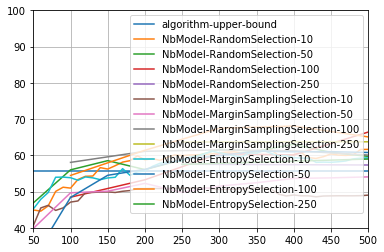

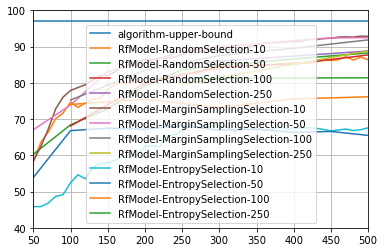

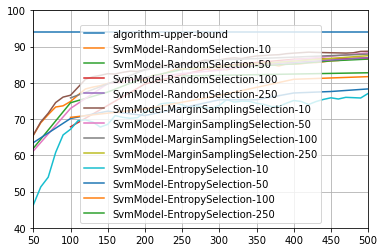

In [17]:
# [nb_upper_bound, svm_upper_bound, rf_upper_bound]\
#     = supervised_accuracies

nb_upper_bound = 55.68
random_forest_upper_bound = 97.
svm_upper_bound = 94.

print('So which is the better model? under the stopping condition' 
      'and hyper parameters - random forest is the winner!')
performance_plot(
    nb_upper_bound, d, ['NbModel'], 
    selection_functions_str, Ks_str, 'accuracy')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    selection_functions_str, Ks_str, 'accuracy')
performance_plot(
    svm_upper_bound, d, ['SvmModel'], 
    selection_functions_str, Ks_str, 'accuracy')

So which is the best sample selection function? margin sampling is the winner!


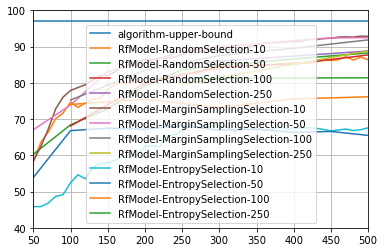

In [19]:
print('So which is the best sample selection function?'
      ' margin sampling is the winner!')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    selection_functions_str, Ks_str, 'accuracy')

So which is the best k? k=10 is the winner


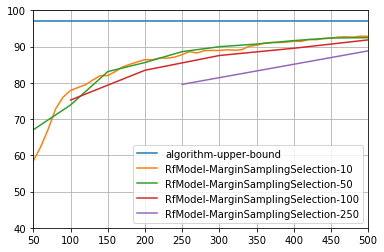

In [20]:
print('So which is the best k? k=10 is the winner')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    ['MarginSamplingSelection'], Ks_str, 'accuracy')

So which is the better model? under the stopping conditionand hyper parameters - random forest is the winner!


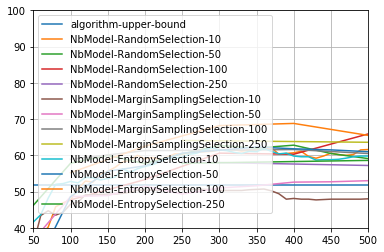

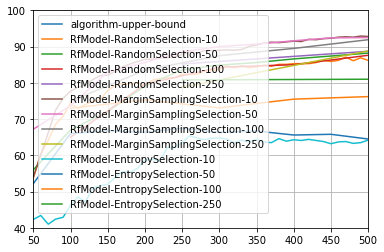

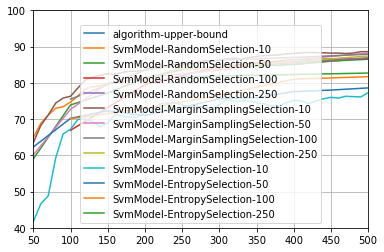

In [22]:
nb_upper_bound = 51.7
random_forest_upper_bound = 0
svm_upper_bound = 0

print('So which is the better model? under the stopping condition'
      'and hyper parameters - random forest is the winner!')
performance_plot(
    nb_upper_bound, d, ['NbModel'], 
    selection_functions_str, Ks_str, 'f1-score')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    selection_functions_str, Ks_str, 'f1-score')
performance_plot(
    svm_upper_bound, d, ['SvmModel'], 
    selection_functions_str, Ks_str, 'f1-score')

So which is the best sample selectionfunction? margin sampling is the winner!


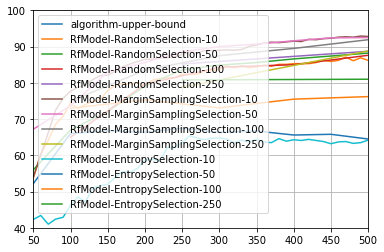

In [23]:
print('So which is the best sample selection' 
      'function? margin sampling is the winner!')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    selection_functions_str, Ks_str, 'f1-score')

So which is the best k? k=10 is the winner


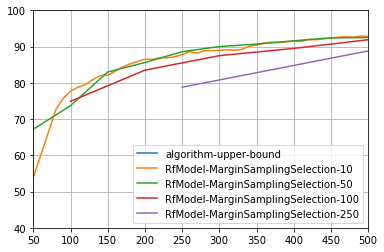

In [24]:
print('So which is the best k? k=10 is the winner')
performance_plot(
    random_forest_upper_bound, d, ['RfModel'], 
    ['MarginSamplingSelection'], Ks_str, 'f1-score')

In [25]:
(X, y) = download('iris')
(X_train_full, y_train_full, X_test, y_test) = split(400)
print ('train:', X_train_full.shape, y_train_full.shape, end='  ')
print ('test :', X_test.shape, y_test.shape, end='  ')
classes = len(np.unique(y))
print ('unique classes', classes)

breast cancer Wisconsin: (569, 30) (569,)
train: (400, 30) (400,)  test : (169, 30) (169,)  unique classes 2


In [35]:
max_queried = 100 
models = [NbModel, SvmModel, RfModel] 
selection_functions = [
    RandomSelection, 
    MarginSamplingSelection, 
    EntropySelection] 
Ks = [5, 10, 20, 50]
Ks_str = [str(k) for k in Ks]

d_wis = {}
stopped_at = -1

d_wis = experiment(d_wis, models, selection_functions, Ks, stopped_at+1)
print(d_wis)

results_wis = json.loads(json.dumps(d_wis, indent=2, sort_keys=True))
print(results_wis)

with open('results_wisconsin.json', 'w') as f:
    json.dump(results_wis, f)

stopping at: 100
Count = 1, using model = NbModel, selection_function = RandomSelection, k = 5
initial random chosen samples (5,)
initial train set: (5, 30) (5,) unique(labels): [1 4] [0 1]
val set: (395, 30) (395,) (5,)
Train set: (5, 30) y: (5,)Val   set: (395, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 1
Example run in 0.002 s
Accuracy rate: 76.923%, F1-score: 0.669
--------------------------------
trainset before (5, 30) (5,)trainset after (10, 30) (10,)
updated train set: (10, 30) (10,) unique(labels): [3 7] [0 1]
val set: (390, 30) (390,)
Train set: (10, 30) y: (10,)Val   set: (390, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 2
Example run in 0.002 s
Accuracy rate: 96.450%, F1-score: 0.963
--------------------------------
trainset before (10, 30) (10,)trainset after (15, 30) (15,)
updated train set: (15, 30) (15,) unique(labels): [ 5 10] [0 1]
val set: (385, 30) (385,)
Train set: (15, 30) y

--------------------------------
Iteration: 3
Example run in 0.002 s
Accuracy rate: 95.858%, F1-score: 0.958
--------------------------------
trainset before (15, 30) (15,)trainset after (20, 30) (20,)
updated train set: (20, 30) (20,) unique(labels): [ 8 12] [0 1]
val set: (380, 30) (380,)
Train set: (20, 30) y: (20,)Val   set: (380, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 4
Example run in 0.002 s
Accuracy rate: 94.675%, F1-score: 0.945
--------------------------------
trainset before (20, 30) (20,)trainset after (25, 30) (25,)
updated train set: (25, 30) (25,) unique(labels): [13 12] [0 1]
val set: (375, 30) (375,)
Train set: (25, 30) y: (25,)Val   set: (375, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 5
Example run in 0.001 s
Accuracy rate: 94.675%, F1-score: 0.947
--------------------------------
trainset before (25, 30) (25,)trainset after (30, 30) (30,)
updated train set: (30, 30) (30,) 

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np

trainset before (30, 30) (30,)trainset after (35, 30) (35,)
updated train set: (35, 30) (35,) unique(labels): [31  4] [0 1]
val set: (365, 30) (365,)
Train set: (35, 30) y: (35,)Val   set: (365, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 7
Example run in 0.001 s
Accuracy rate: 73.964%, F1-score: 0.76
--------------------------------
trainset before (35, 30) (35,)trainset after (40, 30) (40,)
updated train set: (40, 30) (40,) unique(labels): [36  4] [0 1]
val set: (360, 30) (360,)
Train set: (40, 30) y: (40,)Val   set: (360, 30)Test  set: (169, 30)
training Naive Bayes
--------------------------------
Iteration: 8
Example run in 0.001 s
Accuracy rate: 73.964%, F1-score: 0.76
--------------------------------
trainset before (40, 30) (40,)trainset after (45, 30) (45,)
updated train set: (45, 30) (45,) unique(labels): [41  4] [0 1]
val set: (355, 30) (355,)
Train set: (45, 30) y: (45,)Val   set: (355, 30)Test  set: (169, 30)
training Naive Baye

--------------------------------
Iteration: 10
Example run in 0.002 s
Accuracy rate: 97.633%, F1-score: 0.977
--------------------------------
trainset before (50, 30) (50,)trainset after (55, 30) (55,)
updated train set: (55, 30) (55,) unique(labels): [24 31] [0 1]
val set: (345, 30) (345,)
Train set: (55, 30) y: (55,)Val   set: (345, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 11
Example run in 0.001 s
Accuracy rate: 97.633%, F1-score: 0.977
--------------------------------
trainset before (55, 30) (55,)trainset after (60, 30) (60,)
updated train set: (60, 30) (60,) unique(labels): [26 34] [0 1]
val set: (340, 30) (340,)
Train set: (60, 30) y: (60,)Val   set: (340, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 12
Example run in 0.002 s
Accuracy rate: 97.041%, F1-score: 0.971
--------------------------------
trainset before (60, 30) (60,)trainset after (65, 30) (65,)
updated train set: (65, 30) (65,) unique(

trainset before (45, 30) (45,)trainset after (50, 30) (50,)
updated train set: (50, 30) (50,) unique(labels): [28 22] [0 1]
val set: (350, 30) (350,)
Train set: (50, 30) y: (50,)Val   set: (350, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 10
Example run in 0.003 s
Accuracy rate: 95.266%, F1-score: 0.954
--------------------------------
trainset before (50, 30) (50,)trainset after (55, 30) (55,)
updated train set: (55, 30) (55,) unique(labels): [28 27] [0 1]
val set: (345, 30) (345,)
Train set: (55, 30) y: (55,)Val   set: (345, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 11
Example run in 0.002 s
Accuracy rate: 97.633%, F1-score: 0.976
--------------------------------
trainset before (55, 30) (55,)trainset after (60, 30) (60,)
updated train set: (60, 30) (60,) unique(labels): [31 29] [0 1]
val set: (340, 30) (340,)
Train set: (60, 30) y: (60,)Val   set: (340, 30)Test  set: (169, 30)
training SVM...
---------

--------------------------------
Iteration: 8
Example run in 0.002 s
Accuracy rate: 96.450%, F1-score: 0.965
--------------------------------
trainset before (40, 30) (40,)trainset after (45, 30) (45,)
updated train set: (45, 30) (45,) unique(labels): [23 22] [0 1]
val set: (355, 30) (355,)
Train set: (45, 30) y: (45,)Val   set: (355, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 9
Example run in 0.002 s
Accuracy rate: 94.675%, F1-score: 0.948
--------------------------------
trainset before (45, 30) (45,)trainset after (50, 30) (50,)
updated train set: (50, 30) (50,) unique(labels): [24 26] [0 1]
val set: (350, 30) (350,)
Train set: (50, 30) y: (50,)Val   set: (350, 30)Test  set: (169, 30)
training SVM...
--------------------------------
Iteration: 10
Example run in 0.002 s
Accuracy rate: 96.450%, F1-score: 0.965
--------------------------------
trainset before (50, 30) (50,)trainset after (55, 30) (55,)
updated train set: (55, 30) (55,) unique(la

--------------------------------
Iteration: 1
Example run in 0.618 s
Accuracy rate: 80.473%, F1-score: 0.744
--------------------------------
trainset before (5, 30) (5,)trainset after (10, 30) (10,)
updated train set: (10, 30) (10,) unique(labels): [3 7] [0 1]
val set: (390, 30) (390,)
Train set: (10, 30) y: (10,)Val   set: (390, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 0.595 s
Accuracy rate: 93.491%, F1-score: 0.932
--------------------------------
trainset before (10, 30) (10,)trainset after (15, 30) (15,)
updated train set: (15, 30) (15,) unique(labels): [ 5 10] [0 1]
val set: (385, 30) (385,)
Train set: (15, 30) y: (15,)Val   set: (385, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 0.521 s
Accuracy rate: 98.817%, F1-score: 0.988
--------------------------------
trainset before (15, 30) (15,)trainset after (20, 30) (20,)
updated train set: (20, 30) 

--------------------------------
Iteration: 1
Example run in 0.518 s
Accuracy rate: 95.266%, F1-score: 0.951
--------------------------------
trainset before (10, 30) (10,)trainset after (20, 30) (20,)
updated train set: (20, 30) (20,) unique(labels): [ 6 14] [0 1]
val set: (380, 30) (380,)
Train set: (20, 30) y: (20,)Val   set: (380, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 0.516 s
Accuracy rate: 95.858%, F1-score: 0.959
--------------------------------
trainset before (20, 30) (20,)trainset after (30, 30) (30,)
updated train set: (30, 30) (30,) unique(labels): [11 19] [0 1]
val set: (370, 30) (370,)
Train set: (30, 30) y: (30,)Val   set: (370, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 0.527 s
Accuracy rate: 94.083%, F1-score: 0.942
--------------------------------
trainset before (30, 30) (30,)trainset after (40, 30) (40,)
updated train set: (40, 

--------------------------------
Iteration: 1
Example run in 0.565 s
Accuracy rate: 88.757%, F1-score: 0.894
--------------------------------
trainset before (50, 30) (50,)trainset after (100, 30) (100,)
updated train set: (100, 30) (100,) unique(labels): [42 58] [0 1]
val set: (300, 30) (300,)
Train set: (100, 30) y: (100,)Val   set: (300, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 0.547 s
Accuracy rate: 88.757%, F1-score: 0.894
--------------------------------
final active learning accuracies [0.8875739644970414, 0.8875739644970414]
saved Active-learning-experiment-28.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-e

--------------------------------
Iteration: 16
Example run in 0.671 s
Accuracy rate: 97.633%, F1-score: 0.977
--------------------------------
trainset before (80, 30) (80,)trainset after (85, 30) (85,)
updated train set: (85, 30) (85,) unique(labels): [39 46] [0 1]
val set: (315, 30) (315,)
Train set: (85, 30) y: (85,)Val   set: (315, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 17
Example run in 0.607 s
Accuracy rate: 98.225%, F1-score: 0.982
--------------------------------
trainset before (85, 30) (85,)trainset after (90, 30) (90,)
updated train set: (90, 30) (90,) unique(labels): [40 50] [0 1]
val set: (310, 30) (310,)
Train set: (90, 30) y: (90,)Val   set: (310, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 18
Example run in 0.602 s
Accuracy rate: 98.225%, F1-score: 0.982
--------------------------------
trainset before (90, 30) (90,)trainset after (95, 30) (95,)
updated train set: (9

--------------------------------
Iteration: 1
Example run in 0.571 s
Accuracy rate: 94.675%, F1-score: 0.945
--------------------------------
trainset before (20, 30) (20,)trainset after (40, 30) (40,)
updated train set: (40, 30) (40,) unique(labels): [25 15] [0 1]
val set: (360, 30) (360,)
Train set: (40, 30) y: (40,)Val   set: (360, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 2
Example run in 0.642 s
Accuracy rate: 94.083%, F1-score: 0.943
--------------------------------
trainset before (40, 30) (40,)trainset after (60, 30) (60,)
updated train set: (60, 30) (60,) unique(labels): [37 23] [0 1]
val set: (340, 30) (340,)
Train set: (60, 30) y: (60,)Val   set: (340, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 0.656 s
Accuracy rate: 96.450%, F1-score: 0.965
--------------------------------
trainset before (60, 30) (60,)trainset after (80, 30) (80,)
updated train set: (80, 

--------------------------------
Iteration: 6
Example run in 0.538 s
Accuracy rate: 92.308%, F1-score: 0.927
--------------------------------
trainset before (30, 30) (30,)trainset after (35, 30) (35,)
updated train set: (35, 30) (35,) unique(labels): [17 18] [0 1]
val set: (365, 30) (365,)
Train set: (35, 30) y: (35,)Val   set: (365, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 7
Example run in 0.560 s
Accuracy rate: 95.266%, F1-score: 0.953
--------------------------------
trainset before (35, 30) (35,)trainset after (40, 30) (40,)
updated train set: (40, 30) (40,) unique(labels): [18 22] [0 1]
val set: (360, 30) (360,)
Train set: (40, 30) y: (40,)Val   set: (360, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 8
Example run in 0.684 s
Accuracy rate: 98.225%, F1-score: 0.982
--------------------------------
trainset before (40, 30) (40,)trainset after (45, 30) (45,)
updated train set: (45, 

--------------------------------
Iteration: 2
Example run in 0.612 s
Accuracy rate: 95.858%, F1-score: 0.959
--------------------------------
trainset before (20, 30) (20,)trainset after (30, 30) (30,)
updated train set: (30, 30) (30,) unique(labels): [16 14] [0 1]
val set: (370, 30) (370,)
Train set: (30, 30) y: (30,)Val   set: (370, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 3
Example run in 0.653 s
Accuracy rate: 97.041%, F1-score: 0.971
--------------------------------
trainset before (30, 30) (30,)trainset after (40, 30) (40,)
updated train set: (40, 30) (40,) unique(labels): [23 17] [0 1]
val set: (360, 30) (360,)
Train set: (40, 30) y: (40,)Val   set: (360, 30)Test  set: (169, 30)
training Random Forest...
--------------------------------
Iteration: 4
Example run in 0.587 s
Accuracy rate: 96.450%, F1-score: 0.965
--------------------------------
trainset before (40, 30) (40,)trainset after (50, 30) (50,)
updated train set: (50, 

<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


--------------------------------
Iteration: 2
Example run in 0.537 s
Accuracy rate: 97.041%, F1-score: 0.971
--------------------------------
trainset before (40, 30) (40,)trainset after (60, 30) (60,)
updated train set: (60, 30) (60,) unique(labels): [20 40] [0 1]
val set: (340, 30) (340,)
Train set: (60, 30) y: (60,)Val   set: (340, 30)Test  set: (169, 30)
training Random Forest...


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


--------------------------------
Iteration: 3
Example run in 0.670 s
Accuracy rate: 94.083%, F1-score: 0.943
--------------------------------
trainset before (60, 30) (60,)trainset after (80, 30) (80,)
updated train set: (80, 30) (80,) unique(labels): [31 49] [0 1]
val set: (320, 30) (320,)
Train set: (80, 30) y: (80,)Val   set: (320, 30)Test  set: (169, 30)
training Random Forest...


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


--------------------------------
Iteration: 4
Example run in 0.633 s
Accuracy rate: 96.450%, F1-score: 0.965
--------------------------------
trainset before (80, 30) (80,)trainset after (100, 30) (100,)
updated train set: (100, 30) (100,) unique(labels): [39 61] [0 1]
val set: (300, 30) (300,)
Train set: (100, 30) y: (100,)Val   set: (300, 30)Test  set: (169, 30)
training Random Forest...


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


--------------------------------
Iteration: 5
Example run in 0.681 s
Accuracy rate: 97.633%, F1-score: 0.977
--------------------------------
final active learning accuracies [0.9467455621301775, 0.9704142011834319, 0.9408284023668639, 0.9644970414201184, 0.9763313609467456]
saved Active-learning-experiment-35.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pdf', 'Active-learning-experiment-30.pkl', 'Active-learning-experiment-18.pkl', 'Active-learning-experiment-19.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-15.pkl', 'Active-learning-experiment-22.pkl', 'Active-l

--------------------------------
Iteration: 1
Example run in 0.653 s
Accuracy rate: 97.633%, F1-score: 0.976
--------------------------------
trainset before (50, 30) (50,)trainset after (100, 30) (100,)
updated train set: (100, 30) (100,) unique(labels): [59 41] [0 1]
val set: (300, 30) (300,)
Train set: (100, 30) y: (100,)Val   set: (300, 30)Test  set: (169, 30)
training Random Forest...


<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: divide by zero encountered in log2
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)
<ipython-input-5-1f14a73362e9>:24: RuntimeWarning: invalid value encountered in multiply
  entropy = (-probas_val * np.log2(probas_val)).sum(axis=1)


--------------------------------
Iteration: 2
Example run in 0.692 s
Accuracy rate: 90.533%, F1-score: 0.91
--------------------------------
final active learning accuracies [0.9763313609467456, 0.9053254437869822]
saved Active-learning-experiment-36.pkl /home/yxchen/Desktop/Machine Learning in Data Science/Week 13 ['Active-learning-experiment-25.pkl', '.ipynb_checkpoints', 'Active-learning-experiment-21.pkl', 'Active-learning-experiment-13.pkl', 'Active-learning-experiment-5.pkl', 'project_13.ipynb', 'Active-learning-experiment-24.pkl', 'Active-learning-experiment-35.pkl', 'tex', 'Active-learning-experiment-1.pkl', 'Active-learning-experiment-9.pkl', 'ML for DS - WS19-20 - week13__assignment.pdf', 'Active-learning-experiment-30.pkl', 'Active-learning-experiment-18.pkl', 'Active-learning-experiment-19.pkl', 'Active-learning-experiment-10.pkl', 'Active-learning-experiment-15.pkl', 'Active-learning-experiment-22.pkl', 'Active-learning-experiment-20.pkl', 'Active-learning-experiment-16.pk

In [31]:
# compute the supervised accuracy, f1-score
supervised_accuracies_wis, supervised_f1_scores_wis = {}, {}

for model_name in models_str:
    if model_name == 'NbModel':
        classifier = GaussianNB()
    elif model_name == 'SvmModel':
        classifier = SVC(kernel='linear', 
                         probability=True, 
                         class_weight='balanced')
    elif model_name == 'RfModel':
        classifier = RandomForestClassifier(
            n_estimators=500, class_weight='balanced')
    
    # predict
    classifier.fit(X_train_full, y_train_full)
    test_y_predicted = classifier.predict(X_test)

    accuracy = np.mean(test_y_predicted.ravel() == y_test.ravel())
    f1score = f1_score(y_test, test_y_predicted, average='weighted')

    supervised_accuracies_wis[model_name] = accuracy
    supervised_f1_scores_wis[model_name] = f1score

print(supervised_accuracies_wis, supervised_f1_scores_wis)

{'NbModel': 0.9644970414201184, 'SvmModel': 0.9408284023668639, 'RfModel': 0.9644970414201184} {'NbModel': 0.9648032200357781, 'SvmModel': 0.9430069930069931, 'RfModel': 0.9650856003752346}


In [33]:
def performance_plot_wis(supervised_accuracy, dic, models, 
                         selection_functions, Ks, metric='accuracy'):  
    fig, ax = plt.subplots()
    ax.plot([0,100],
            [supervised_accuracy, supervised_accuracy], 
            label = 'algorithm-upper-bound')
    
    metric_id = 0 if metric == 'accuracy' else 1
    for model_object in models:
        for selection_function in selection_functions:
            for idx, k in enumerate(Ks):
                x = np.arange(float(Ks[idx]), 100 + float(Ks[idx]), float(Ks[idx]))            
                y = np.array(dic[model_object][selection_function][k][0][metric_id])
                y = 100 * y
                label_ = model_object + '-' + selection_function + '-' + str(k)
                plt.plot(x, y, label=label_)
                
    ax.legend()
    ax.set_xlim([10,100])
    ax.set_ylim([70,100])
    ax.grid(True)
    plt.show()

So which is the better model? under the stopping conditionand hyper parameters - random forest is the winner!


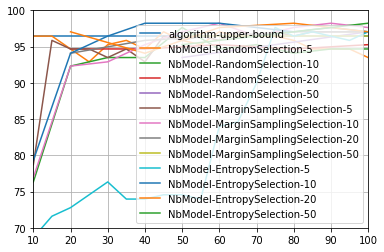

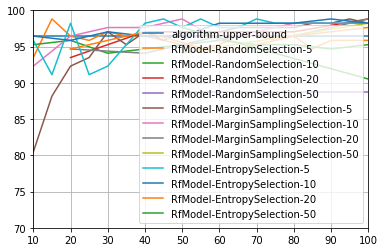

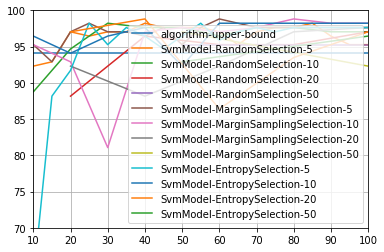

In [36]:
nb_upper_bound_wis = 96.45
random_forest_upper_bound_wis = 96.45
svm_upper_bound_wis = 94.08

print('So which is the better model? under the stopping condition'
      'and hyper parameters - random forest is the winner!')
performance_plot_wis(
    nb_upper_bound_wis, d_wis, ['NbModel'], 
    selection_functions_str, Ks_str, 'accuracy')
performance_plot_wis(
    random_forest_upper_bound_wis, d_wis, ['RfModel'], 
    selection_functions_str, Ks_str, 'accuracy')
performance_plot_wis(
    svm_upper_bound_wis, d_wis, ['SvmModel'], 
    selection_functions_str, Ks_str, 'accuracy')

In [37]:
print('So which is the best sample selection' 
      'function? margin sampling is the winner!')
performance_plot_wis(
    random_forest_upper_bound, d_wis, ['RfModel'], 
    selection_functions_str, Ks_str, 'accuracy')

So which is the best sample selectionfunction? margin sampling is the winner!


So which is the best k? k=10 is the winner


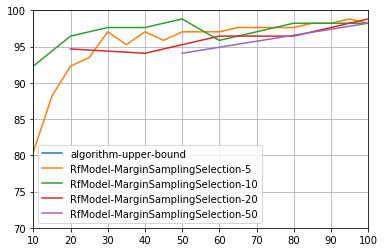

In [39]:
print('So which is the best k? k=10 is the winner')
performance_plot_wis(
    random_forest_upper_bound, d_wis, ['RfModel'], 
    ['MarginSamplingSelection'], Ks_str, 'accuracy')